In [22]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

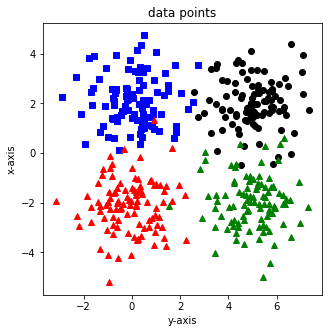

In [23]:
# create data

# number of cluster of points
nPerClust = 100
blur = 1 # variance

# initial starting points of the seperate colours
# mean values used for random.randn which is based on normal distribution
A = [  0,  2 ] 
B = [  5,  2 ]
C = [  0, -2 ]
D = [  5, -2 ]

# generate data in the same area based on random.randn
# random.randn creates random points between points based on the normal distribution
# [array([x1, y1]), array([x2, y2], ..., array([xn, yn]))]
# a/b/c/d is [2, 100] which means 2 rows, 100 columns. We have two rows because x/y (it is a coordinate).
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ] # e.g: [0+0.5 = 0.5, 2+-0.25=1.75] = [0.5, 1.75] which is in the same area as [0,2]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]
d = [ D[0]+np.random.randn(nPerClust)*blur , D[1]+np.random.randn(nPerClust)*blur ]
# a = np.array(a)
# print(a.shape)

# true labels - creating 100 0s of type float, creating 100 1s of type float, creating 100 2s of type float and creating 100 3s of type float in one list vertically.
labels1 = np.zeros((nPerClust,1)) # [100, 1], 100 rows, 1 column
labels2 = np.ones((nPerClust,1))
labels3 = 1+np.ones((nPerClust,1))
labels4 = 2+np.ones((nPerClust,1))
labels_np = np.vstack((labels1, labels2, labels3, labels4)) # [400, 1], 400 rows, 1 column

# concatanate into a matrix all the data points from a, b, c and d
# [400, 2], 400 rows, 2 column
data_np = np.hstack((a,b,c,d)) # 400 because 100*4 and 2 because concatinating the coordinates of x and y ([2, 400])
data_np = data_np.T # ([400, 2]). This means 400 rows with 2 columns

# convert np matrix to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # long makes the values integers with unlimited length. We do this to have consistent values so when getitng output prob, they sum to 1.
labels = torch.squeeze(labels) # Converts from 2D ([400, 1]) into 1D [400]. .squeeze method removes dimension size of 1 from the tensor. We do this to make sure it can be inputted into lossfun() which requires 0D/1D dimensional array.

# show the data
fig = plt.figure(figsize=(5,5))

# np.where will print the values where condition is satisfied
# example: for data[np.where==0)[0], 0] in the table of data if first index = 0 then show
# plt.plot(x, y, colour)
# - data[399][0] means we are accessing the 399th coordinate and getting the x coordinate
# - data[287][1] means we accessing the 287th coordinate and getting the y coordinate
# print(data[np.where(labels==0)]) returns an array containing 100 arrays with length 2 (when labels=0). So we access the 100 arrays with np.where(labels==0)[0]
# np.where(labels==0)[0][0]) to access x whereas np.where(labels==0)[0][1]) accesses y
# Remember: first 100 coordinates correspond to 0 values in labels (blue), second 100 coordinates correspond to 1 values in labels (black), etc ...
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1], 'r^')
plt.plot(data[np.where(labels==3)[0],0], data[np.where(labels==3)[0],1], 'g^')

plt.title('data points') # title of graph
plt.xlabel('y-axis') # x-axis title
plt.ylabel('x-axis') # y-axis title
plt.show() # present the graph

In [24]:
# model architecture
ANNclassify = nn.Sequential(
    nn.Linear(2,5),   # input layer
    nn.Linear(5,4),   # middle layer
    # nn.Softmax(dim=1), # (BETTER WITHOUT, BUT GOOD TO CHECK GRAPH BELOW) modifies the output layer into probabilities
      )

In [25]:
# other model features

learningRate = 0.01

# loss function of cross entropy
# uses log(SoftMax) for better optimisation (no need for SoftMax above technically)
lossfun = nn.CrossEntropyLoss()

# optimizer - standard gradient descent algorithm
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=0.01)


In [26]:
numepochs = 10000 # number of iterations

# initialize losses
losses = torch.zeros(numepochs) # creates an list of 1000 0s
ongoingAcc = [] # stores the accuracy values

# loop over epochs
for epochi in range(numepochs):

  # forward pass - takes input and runs in model. Returns and stores in yHat.
  # yHat - [400, 4]
  yHat = ANNclassify(data) # predicts input data is either 0, 1, 2, 3 in terms of probability (softmax) and stores in yHat

  # compute loss
  loss = lossfun(yHat,labels) # calculates the loss by comparing the actual and predicted(yHat)
  losses[epochi] = loss # stores loss for each iteration of epochi

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy all values in YHat corresponding to labels
  # remember: labels is in sequential order from 0-3 and yHat is in seqential order predicting inputs from region0-region1-region2-region3.
  # hence, they should correspond to each other that is why we do max(yHat[i]) == labels

  # we have 4 variables with varying probabilities stored in yHat (the output of the model)
  # we choose the maximum probability value. This is the category we predict it being
  matches = torch.argmax(yHat,axis=1) == labels # list of booleans (false/true)
  matchesNumeric = matches.float()               # list of booleans converted to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # averaging list of numbers and x100 
  ongoingAcc.append( accuracyPct )              # add average to ongoingAcc (list of accuracies)


# final forward pass to get predictions
predictions = ANNclassify(data)
  
# doing final check of accuracy in model - samething as above
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

Final accuracy: 96.25%


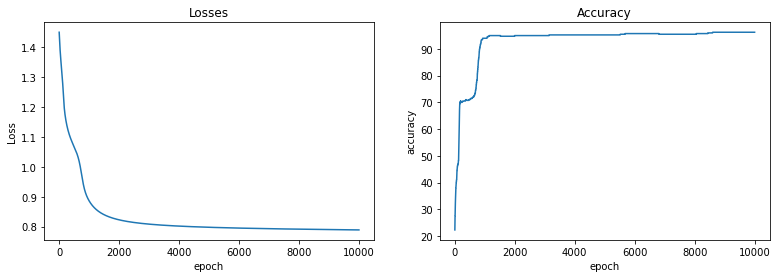

In [27]:
# report accuracy - what number of points were correct on the graph divided by total points evaluated
print('Final accuracy: %g%%' %totalacc)

fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach()) # gets numerical value (in this case list) from the tensor
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()

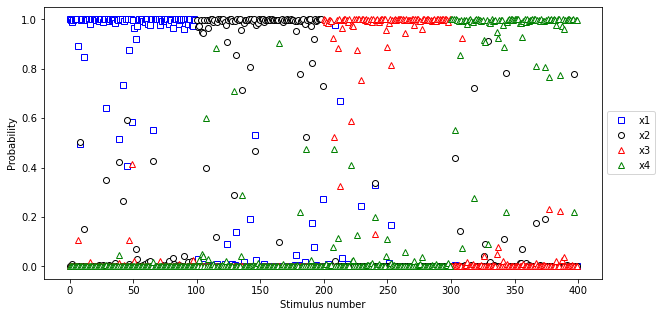

In [28]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,5))

# corresponding each category as one colour
# 0 - blue
# 1 - black 
# 2 - red
# 3 - green
colorshape = [  'bs','ko','r^', 'g^']

# presenting each data point predicted in yHat - final model prediction outcome
# plt.plot takes 3 arguments, (1) arguments for coordinates (2) colour shape of the element on the graph and (3) markerface is the type of shading on the element on the graph
# .detach gets the numerical value
for i in range(4):
    plt.plot(yHat[:,i].detach(),colorshape[i],markerfacecolor='w') 

plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['x1','x2','x3', 'x4'],loc='center left', bbox_to_anchor=(1, 0.5)) #loc and bbox_t0_anchor determine position of legend
plt.show()